In [ ]:
import sys
sys.path.append("../../PEVAE_Paper/pfam_msa")
import script
import pickle
from Bio import SeqIO
from collections import OrderedDict
import os

## Create Training data

In [ ]:
# train = SeqIO.parse("../data/training_spike.fasta", "fasta")
# MSA_dict = OrderedDict()
# for t in iter(train):
#     MSA_dict[t.id] = t.seq
# with open("./output/training_aligned.pkl", "wb") as f:
#     pickle.dump(MSA_dict, f)

## Create Validation data

In [ ]:
# valid = SeqIO.parse("../data/valid_spike.fasta", "fasta")
# MSA_dict = OrderedDict()
# for t in iter(valid):
#     MSA_dict[t.id] = t.seq
# with open("./output/valid_aligned.pkl", "wb") as f:
#     pickle.dump(MSA_dict, f)

In [ ]:
# %cd ~/code/PEVAE_Paper/simulated_msa
# !python ./script/read_LG_matrix.py

In [ ]:
# %cd ~/code/sequence-vaes/VAE_ding
# !python ../../PEVAE_Paper/simulated_msa/script/proc_msa.py

## Evaluate model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sys import exit
import sys
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
import pandas as pd

sys.path.append("../../PEVAE_Paper/simulated_msa/script")
from VAE_model import *

In [2]:
sys.path.append("../VAE_standard/")
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM

## loss figs

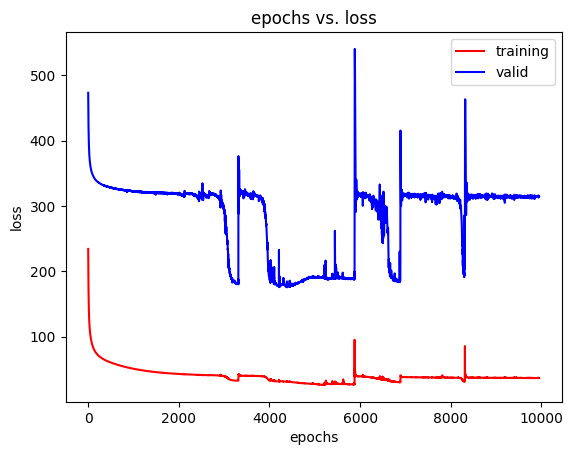

In [3]:
data = None
with open("./output/loss.pkl", "rb") as f:
    data = pickle.load(f)

# looking at losses after first 50 epochs to see actual data
train_losses = data["train_loss_epoch"][50:]
valid_losses = data["valid_loss_epoch"][50:]

N = len(train_losses)
assert N == len(valid_losses)

plt.plot(list(range(N)), train_losses, label="training", color="r")
plt.plot(list(range(N)), valid_losses, label="valid", color="b")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("epochs vs. loss")
plt.legend()
plt.show()

## hamming vs euclid

In [4]:
# "":= train, "valid_" := valid
eval_list = ["training", "valid"] 
eval_type = eval_list[1]

with open(f"./output/{eval_type}_msa_leaf_binary.pkl", 'rb') as file_handle:
    msa_binary = pickle.load(file_handle)    
num_seq = msa_binary.shape[0]
len_protein = msa_binary.shape[1]
num_res_type = msa_binary.shape[2]
msa_binary = msa_binary.reshape((num_seq, -1))
msa_binary = msa_binary.astype(np.float32)

## each sequence has a label
with open(f"./output/{eval_type}_msa_leaf_keys.pkl", 'rb') as file_handle:
    msa_keys = pickle.load(file_handle)

## sequences in msa are weighted. Here sequences are assigned
## the same weights
msa_weight = np.ones(num_seq) / num_seq
msa_weight = msa_weight.astype(np.float32)

#### construct the MSA dataseta and DataLoader
## the model is trained with batches of data.
## here we choose the batch size to be equal to the total number
## of sequences because the GPU usually has large enough memory
## for it. If you are running the code on a GPU with small memory and
## have GPU memory error, try to decrease the batch_size
batch_size = num_seq
data = MSA_Dataset(msa_binary, msa_weight, msa_keys)

print(num_seq)

360


In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

input_dim = SEQ_LENGTH * len(ALPHABET)

vae_model = VAE(num_aa_type = 21,
          dim_latent_vars = 2,
          dim_msa_vars = len_protein*num_res_type,
          num_hidden_units = [100])
vae_model.cuda()

vae_model.load_state_dict(torch.load("./output/vae_6000.model", weights_only=True, map_location=DEVICE))

cuda


/home/averma2/miniforge3/envs/Moreta_env/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

In [6]:
dset = "valid"
abspath = ".."
dataset = DNADataset(f"{abspath}/data/{dset}_spike.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])
vals = np.array([dataset[x][1] for x in range(len(dataset))])
# labeling
metadata = pd.read_csv(f"{abspath}/data/all_data/all_metadata.tsv", sep="\t")
clade_labels = [metadata.loc[metadata.name == vals[i], "clade_membership"].values[0] for i in range(len(vals))]

In [7]:
good_clade_labels = []
for c in clade_labels:
    if len(metadata[metadata.clade_membership == c]) > 5:
        good_clade_labels.append(c)
print(set(good_clade_labels))

{'22A (BA.4)', '22B (BA.5)', '21A (Delta)', '21J (Delta)', '21I (Delta)', '21K (BA.1)', '20I (Alpha)', '22C (BA.2.12.1)', '20H (Beta)', '22D (BA.2.75)', '20J (Gamma)', '21L (BA.2)'}


In [8]:
# print(set(clade_labels))

clusters = np.array(list(set(good_clade_labels)))[:3]
print(clusters)
get_clade = lambda x: [True if elem == x else False for elem in clade_labels]

indexes = tuple([np.arange(len(clade_labels))[get_clade(x)] for x in clusters])

['22A (BA.4)' '22B (BA.5)' '21A (Delta)']


In [9]:
new_vals = []
for v in vals:
    if metadata.loc[metadata.name == v, "clade_membership"].values[0] in clusters:
        new_vals.append(v)

In [10]:
parents = pd.read_csv(f"{abspath}/data/all_data/all_branches.tsv", sep="\t")
node_dict = {x:i for i,x in enumerate(new_vals)}
pairs = []
for p,c in zip(parents["parent"], parents["child"]):
    i1 = node_dict.get(p, None)
    i2 = node_dict.get(c, None)

    if i1 and i2:
        pairs.append((i1,i2))

pairs = np.array(pairs)

X shape
(360, 3822, 5)
torch.Size([360, 80262])
torch.Size([360, 2])

Recon shape
(360, 80262)

----------------

[0.5114411 0.3107213]
total variance: 0.822162389755249

[9.9999535e-01 3.3283770e-06]
total variance: 0.9999986886978149


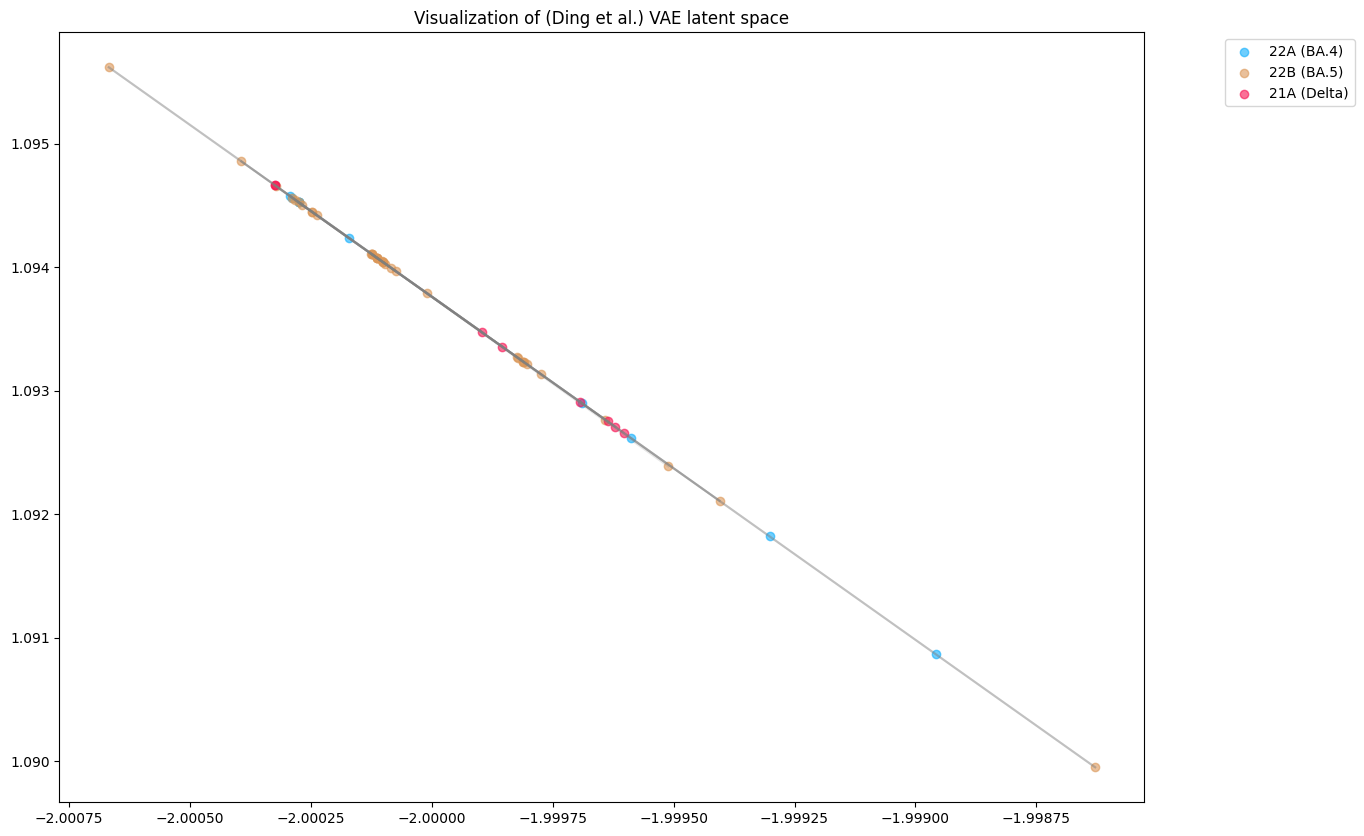

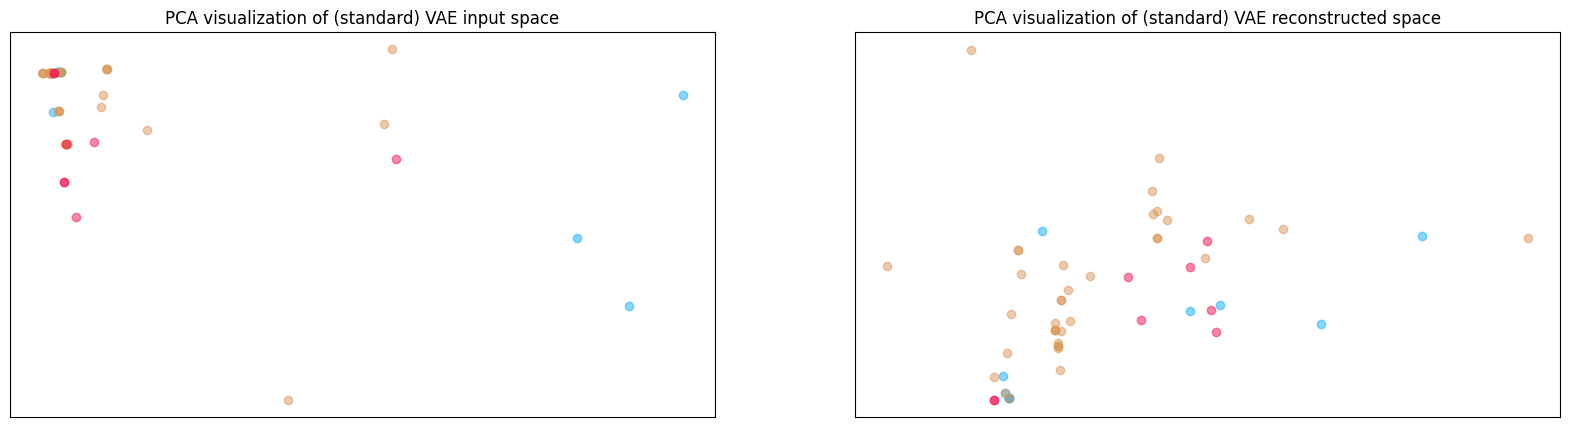

In [17]:
import matplotlib.colors as mcolors
import random
# colors = list(mcolors.TABLEAU_COLORS.keys())

random.seed(10)
# colors = ['#%06X' % int(x) for x in np.linspace(0, 0xFFFFFF, num=len(indexes))]
colors = []
for i in range(len(indexes)):
    colors.append('#%06X' % random.randint(0, 0xFFFFFF))

ranges = np.concatenate(indexes)

X, weight, _ = next(iter(DataLoader(data, batch_size = batch_size, shuffle = False)))
X = X.to(DEVICE)
print("X shape")
print(new_dataset.shape)
print(X.shape)
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)

fig,ax = plt.subplots(1,1,figsize=(14,10))
recon = None
with torch.no_grad():
    Z_mean, Z_logvar = vae_model.encoder(X)
    Z_mean = Z_mean.cpu()
    Z_std = torch.exp(0.5 * Z_logvar).cpu()
    recon = vae_model.decoder(Z_mean.to(DEVICE)).cpu().numpy()
    print(Z_mean.shape)
    print("\nRecon shape")
    print(recon.shape)
    
    Z_embedded = Z_mean # no need for PCA since latent space is 2 dim
    curr = 0
    for i,arr in enumerate(indexes):
        loc_arr = list(range(curr,curr + len(arr),1))
        # print(set([clade_labels[x] for x in ranges[loc_arr]]))
        ax.scatter(Z_embedded[loc_arr,0], Z_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.6, color=colors[i])
        curr += len(arr)

    for p in pairs:
        ax.plot(Z_embedded[p,0], Z_embedded[p,1], color="gray", alpha=0.2)

l1 = 0.1
l2 = 0
ax.set_title("Visualization of (Ding et al.) VAE latent space")
ax.legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))

fig,ax = plt.subplots(1,2,figsize=(20,5))
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.axis("on")

ax[0].set_title("PCA visualization of (standard) VAE input space")
print("\n----------------\n")
pca = PCA(n_components=2)
pca.fit(X=X.cpu().numpy())
X_embedded = pca.transform(X=X.cpu().numpy())
variances = pca.explained_variance_ratio_
tot = np.sum(variances)
print(variances)
print(f"total variance: {tot}\n")
curr = 0
for i,arr in enumerate(indexes):
    loc_arr = list(range(curr,curr + len(arr),1))
    ax[0].scatter(X_embedded[loc_arr,0], X_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.5, color=colors[i])
    curr += len(arr)

ax[1].set_title("PCA visualization of (standard) VAE reconstructed space")
pca = PCA(n_components=2)
pca.fit(X=recon)
recon_embedded = pca.transform(X=recon)
variances = pca.explained_variance_ratio_
tot = np.sum(variances)
print(variances)
print(f"total variance: {tot}")
curr = 0
for i,arr in enumerate(indexes):
    loc_arr = list(range(curr,curr + len(arr),1))
    ax[1].scatter(recon_embedded[loc_arr,0], recon_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.5, color=colors[i])
    curr += len(arr)
# ax[1].legend(bbox_to_anchor=(l1,l2,l1+1,l2+1)) 
plt.show()

In [14]:
dset = "valid"


X, weight, _ = next(iter(DataLoader(data, batch_size = batch_size, shuffle = False)))
X = X.to(DEVICE)

Z_mean, Z_logvar = vae_model.encoder(X)

X = X.view(X.shape[0], -1, 21)
print(X.shape)
genome = np.matmul(X.cpu().numpy(), np.arange(21))
print(X.size(1))
print(genome.shape[1])
hamming_dists = []
euclid_dists = []

for i in range(X.size(0)):
    for j in range(i+1, X.size(0)):
        ham_d = np.sum(np.not_equal(genome[i,:],genome[j,:]))
        euclid_d = torch.norm(Z_mean[i,:] - Z_mean[j,:]).cpu().detach()
        hamming_dists.append(ham_d)
        euclid_dists.append(euclid_d)



torch.Size([360, 3822, 21])
3822
3822


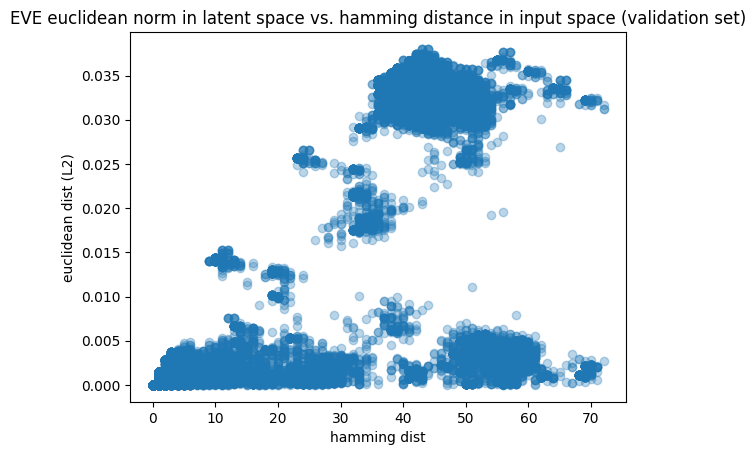

In [15]:
plt.scatter(hamming_dists, euclid_dists, alpha=0.3)
plt.title("EVE euclidean norm in latent space vs. hamming distance in input space (validation set)")
plt.xlabel("hamming dist")
plt.ylabel("euclidean dist (L2)")
plt.show()

In [16]:
print(np.corrcoef(np.vstack((euclid_dists, hamming_dists)))[1,0])

0.5572607172427517
